# Google Colab Setup

Please run the code below to mount drive if you are running on colab.

Please ignore if you are running on your local machine.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#anthony + kapes
%cd /content/drive/MyDrive/MiniGPT/

#Gavin
# %cd /content/drive/MyDrive/Undergraduate/Junior/Spring 2024/ECE 239 AS - Labs/MiniGPT

/content/drive/.shortcut-targets-by-id/1UJj3AdgcR_Ocb-ytuptvDIHzKtU_FcA1/MiniGPT


# Language Modeling and Transformers

The project will consist of two broad parts.

1. **Baseline Generative Language Model**: We will train a simple Bigram language model on the text data. We will use this model to generate a mini story.
2. **Implementing Mini GPT**: We will implement a mini version of the GPT model layer by layer and attempt to train it on the text data. You will then load pretrained weights provided and generate a mini story.

## Some general instructions

1. Please keep the name of layers consistent with what is requested in the `model.py` file for each layer, this helps us test in each function independently.
2. Please check to see if the bias is to be set to false or true for all linear layers (it is mentioned in the doc string)
3. As a general rule please read the docstring well, it contains information you will need to write the code.
4. All configs are defined in `config.py` for the first part while you are writing the code do not change the values in the config file since we use them to test. Once you have passed all the tests please feel free to vary the parameter as you please.
5. You will need to fill in the `train.py` and run it to train the model. If you are running into memory issues please feel free to change the `batch_size` in the `config.py` file. If you are working on Colab please make sure to use the GPU runtime and feel free to copy over the training code to the notebook.

In [ ]:
!pip install numpy torch tiktoken wandb einops # Install all required packages

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x8

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
import tiktoken

In [ ]:
from model import BigramLanguageModel, SingleHeadAttention, MultiHeadAttention, FeedForwardLayer, LayerNorm, TransformerLayer, MiniGPT
from config import BigramConfig, MiniGPTConfig
import tests

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
path_to_bigram_tester = "./pretrained_models/bigram_tester.pt" # Load the bigram model with name bigram_tester.pt
path_to_gpt_tester = "./pretrained_models/minigpt_tester.pt" # Load the gpt model with name minigpt_tester.pt

##  Bigram Language Model (10 points)

A bigram language model is a type of probabilistic language model that predicts a word given the previous word in the sequence. The model is trained on a text corpus and learns the probability of a word given the previous word.



### Implement the Bigram model (5 points)

Please complete the `BigramLanguageModel` class in model.py. We will model a Bigram language model using a simple MLP with one hidden layer. The model will take in the previous word index and output the logits over the vocabulary for the next word.

In [ ]:
# Test implementation for Bigram Language Model
model = BigramLanguageModel(BigramConfig)
tests.check_bigram(model,path_to_bigram_tester, device)

'TEST CASE PASSED!!!'

In [ ]:
"""
Training file for the models we implemented
"""

from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.utils
from torch.utils.data import DataLoader
from einops import rearrange
import wandb

from model import BigramLanguageModel, MiniGPT
from dataset import TinyStoriesDataset
from config import BigramConfig, MiniGPTConfig


MODEL = "bigram"  # bigram or minigpt

if MODEL == "bigram":
    config = BigramConfig
    model = BigramLanguageModel(config)
elif MODEL == "minigpt":
    config = MiniGPTConfig
    model = MiniGPT(config)
else:
    raise ValueError("Invalid model name")


# Initialize wandb if you want to use it
if config.to_log:
    wandb.init()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


train_dataset = TinyStoriesDataset(
    config.path_to_data,
    mode="train",
    context_length=config.context_length,
)
eval_dataset = TinyStoriesDataset(
    config.path_to_data, mode="test", context_length=config.context_length
)

train_dataloader = DataLoader(
    train_dataset, batch_size=config.batch_size, pin_memory=True
)
eval_dataloader = DataLoader(
    eval_dataset, batch_size=config.batch_size, pin_memory=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("number of trainable parameters: %.2fM" % (count_parameters(model) / 1e6,))


if not Path.exists(config.save_path):
    Path.mkdir(MiniGPTConfig.save_path, parents=True, exist_ok=True)


### ==================== START OF YOUR CODE ==================== ###
"""
You are required to implement the training loop for the model.

Please keep the following in mind:
- You will need to define an appropriate loss function for the model.
- You will need to define an optimizer for the model.
- You are required to log the loss (either on wandb or any other logger you prefer) every `config.log_interval` iterations.
- It is recommended that you save the model weights every `config.save_iterations` iterations you can also just save the model with the best training loss.

Please check the config file to see the different configurations you can set for the model.
NOTE :
The MiniGPT config has params that you do not need to use, these were added to scale the model but are
not a required part of the assignment.
Feel free to experiment with the parameters and I would be happy to talk to you about them if interested :)
"""
import torch.optim as optim
import os
import matplotlib.pyplot as plt

def train(model, train_dataloader, eval_dataloader, config):
    model.to(device)
    model.train()

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    # Optionally initialize wandb logging
    if config.to_log:
        wandb.watch(model)

    # Lists to store loss values for plotting
    train_losses = []
    eval_losses = []

    # Training loop
    for epoch in range(config.max_iter):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader, 0):
            if i >= 5000:
              break
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Log statistics
            running_loss += loss.item()
            if i % config.log_interval == (config.log_interval - 1):  # Log every log_interval mini-batches
                avg_loss = running_loss / config.log_interval
                train_losses.append(avg_loss)
                if config.to_log:
                    wandb.log({"loss": avg_loss})
                running_loss = 0.0

            # Save the model every save_iterations
            if i % config.save_iterations == (config.save_iterations - 1):
                save_model(model, config.save_path, epoch, i)

        # Optionally evaluate the model after each epoch
        eval_loss = evaluate(model, eval_dataloader, config, criterion)
        eval_losses.append(eval_loss)
        return eval_losses, train_losses

    print("Finished Training")
    save_model(model, config.save_path, epoch, i)

    # Plot the losses
    plot_losses(train_losses, eval_losses, config)

def evaluate(model, eval_dataloader, config, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        i = 0
        for data in eval_dataloader:
            if i >= 5000:
              break
            i += 1
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
            total_loss += loss.item()

    avg_loss = total_loss / len(eval_dataloader)
    print(f"Evaluation loss: {avg_loss:.3f}")
    if config.to_log:
        wandb.log({"eval_loss": avg_loss})
    model.train()
    return avg_loss

def save_model(model, path, epoch, iteration):
    save_path = os.path.join(path, f"model_epoch{epoch}_iter{iteration}.pth")
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

def plot_losses(train_losses, eval_losses, config):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(eval_losses, label='Evaluation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Loss')
    plt.legend()
    plt.savefig(os.path.join(config.save_path, 'loss_plot.png'))
    plt.show()

# Start the training process
eval_losses, train_losses = train(model, train_dataloader, eval_dataloader, config)



number of trainable parameters: 3.27M
Evaluation loss: 0.199


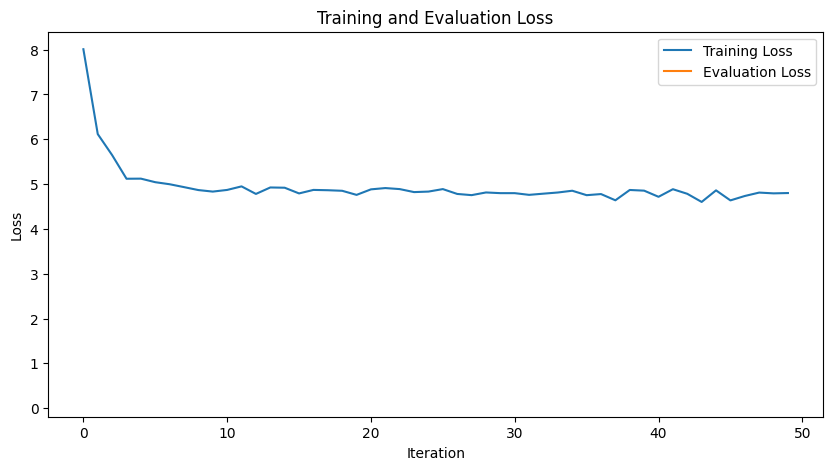

In [ ]:
plot_losses(train_losses, eval_losses, config)

### Training the Bigram Language Model (2.5 points)

Complete the code in `train.py` to train the Bigram language model on the text data. Please provide plots for both the training and validation in the cell below.

Some notes on the training process:

1. You should be able to train the model slowly on your local machine.
2. Training it on Colab will help with speed.
3.  <span style="color:red">To get full points for this section it is sufficient to show that the loss is decreasing over time</span>. You should see it saturate to a value close to around 5-6 but as long as you see it decreasing then saturating you should be good.
4. Please log the loss curves either on wandb, tensorboard or any other logger of your choice and please attach them below.

### Train and Valid Plots


** Show the training and validation loss plots **

### Generation (2.5 points)

Complete the code in the `generate` method of the Bigram class and generate a mini story using the trained Bigram language model. The model will take in the previous word index and output the next word index.

Start with the following seed sentence:
    
    `"once upon a time"`
    

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
# gen_sent = "Once upon a time"
# gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
# print("Generating text starting with:", gen_tokens.shape)
# gen_tokens = gen_tokens.to(device)
# model.eval()
# print(
#     tokenizer.decode(
#         model.generate(gen_tokens, max_new_tokens=200).squeeze().tolist()
#     )
# )
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
# gen_sent = "Once upon a time"

# # Encode the input sentence
# gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
# gen_tokens = gen_tokens.to(device)
# print("Generating text starting withh:", gen_tokens)

# # Initialize and evaluate your model
# model.to(device)
# model.eval()

# # Generate new tokens
# generated_tokens = model.generate(gen_tokens, max_new_tokens=200)

# # Decode the generated tokens back to text
# generated_text = tokenizer.decode(generated_tokens)
# print(generated_text)



print(device)
gen_sent = "Once upon a time"

# Encode the input sentence
gen_tokens = torch.tensor(tokenizer.encode(gen_sent)).to(device)
print("Generating text starting with:", gen_tokens)

# Initialize and evaluate your model
model.to(device)
model.eval()

# Generate new tokens
generated_tokens = model.generate(gen_tokens, max_new_tokens=200)

# Decode the generated tokens back to text
generated_text = tokenizer.decode(generated_tokens.squeeze().tolist())
print(generated_text)

cuda
Generating text starting with: tensor([7454, 2402,  257,  640], device='cuda:0')
Once upon a time, "Thank you ready for balls, on, Lily gave them. cookies and pointing to agreed and put the train made what.. Timmy was mean to draw that day he made you know, "I remember to making lunch." The diamond and cook wondering give Lily put before it could mommy turned, the table. He note he could run. The ants!" hid under the bush. The of the Max.Once upon a light. counting and inside. Timmy was. He was a picture and all ate to catch a big wall on, better started to play want to polish the your bug was toy box could and wanted to sure she was more fun. dancer was market, we can't mind. The children were better. swing at the picture. From that she could play. I found the rich hanging there was back at the birds could run in a big time, the walk.Once upon a time, toy piece of the kids what you important to hurt make cried were embarrassed Leo


### Observation and Analysis

Please answer the following questions.

1. What can we say about the generated text in terms of grammar and coherence?
2. What are the limitations of the Bigram language model?
3. If the model is scaled with more parameters do you expect the bigram model to get substantially better? Why or why not?

## Mini GPT (90 points)

We will not implement a decoder style transformer model like we discussed in lecture, which is a scaled down version of the [GPT model](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf).

All the model components follow directly from the original [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper. The only difference is we will use prenormalization and learnt positional embeddings instead of fixed ones. But you will not need to worry about these details!

We will now implement each layer step by step checking if it is implemented correctly in the process. We will finally put together all our layers to get a fully fledged GPT model.

<span style="color:red">Later layers might depend on previous layers so please make sure to check the previous layers before moving on to the next one.</span>

### Single Head Causal Attention (20 points)

We will first implement the single head causal attention layer. This layer is the same as the scaled dot product attention layer but with a causal mask to prevent the model from looking into the future.

Recall that Each head has a Key, Query and Value Matrix and the scaled dot product attention is calculated as :

\begin{equation}
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
\end{equation}

where $d_k$ is the dimension of the key matrix.

Figure below from the original paper shows how the layer is to be implemented.

![image](./Images/Single_Head.png)

Image credits: [Attention is All You Need Paper](https://arxiv.org/abs/1706.03762)

Please complete the `SingleHeadAttention` class in `model.py`

In [ ]:
model = SingleHeadAttention(MiniGPTConfig.embed_dim, MiniGPTConfig.embed_dim//4, MiniGPTConfig.embed_dim//4) # configs are set as such for testing do not modify

tests.check_singleheadattention(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Multi Head Attention (10 points)

Now that we have a single head working, we will now scale this across multiple heads, remember that with multihead attention we compute perform head number of parallel attention operations. We then concatenate the outputs of these parallel attention operations and project them back to the desired dimension using an output linear layer.

Figure below from the original paper shows how the layer is to be implemented.

![image](./Images/MultiHead.png)

Image credits: [Attention is All You Need Paper](https://arxiv.org/abs/1706.03762)

Please complete the `MultiHeadAttention` class in `model.py` using the `SingleHeadAttention` class implemented earlier.

In [ ]:
model = MultiHeadAttention(MiniGPTConfig.embed_dim, MiniGPTConfig.num_heads)

tests.check_multiheadattention(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Feed Forward Layer (5 points)

As discussed in lecture, the attention layer is completely linear, in order to add some non-linearity we add a feed forward layer. The feed forward layer is a simple two layer MLP with a GeLU activation in between.

Please complete the `FeedForwardLayer` class in `model.py`

In [ ]:
model = FeedForwardLayer(MiniGPTConfig.embed_dim)

tests.check_feedforward(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### LayerNorm (10 points)

We will now implement the layer normalization layer. Layernorm is used across the model to normalize the activations of the previous layer. Recall that the equation for layernorm is given as:

\begin{equation}

\text{LayerNorm}(x) = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} \odot \gamma + \beta

\end{equation}

With the learnable parameters $\gamma$ and $\beta$.

Remember that unlike batchnorm we compute statistics across the feature dimension and not the batch dimension, hence we do not need to keep track of running averages.

Please complete the `LayerNorm` class in `model.py`

In [ ]:
model = LayerNorm(MiniGPTConfig.embed_dim)
tests.check_layernorm(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Transformer Layer (15 points)

We have now implemented all the components of the transformer layer. We will now put it all together to create a transformer layer. The transformer layer consists of a multi head attention layer, a feed forward layer and two layer norm layers.

Please use the following order for each component (Varies slightly from the original attention paper):
1. LayerNorm
2. MultiHeadAttention
3. LayerNorm
4. FeedForwardLayer

Remember that the transformer layer also has residual connections around each sublayer.

The below figure shows the structure of the transformer layer you are required to implement.

![prenorm_transformer](./Images/Prenorm.png)

Image Credit : [CogView](https://arxiv.org/pdf/2105.13290)

Implement the `TransformerLayer` class in `model.py`

In [ ]:
model =  TransformerLayer(MiniGPTConfig.embed_dim, MiniGPTConfig.num_heads)
tests.check_transformer(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Putting it all together : MiniGPT (15 points)

We are now ready to put all our layers together to build our own MiniGPT!

The MiniGPT model consists of an embedding layer, a positional encoding layer and a stack of transformer layers. The output of the transformer layer is passed through a linear layer (called head) to get the final output logits. Note that in our implementation we will use [weight tying](https://arxiv.org/abs/1608.05859) between the embedding layer and the final linear layer. This allows us to save on parameters and also helps in training.

Implement the `MiniGPT` class in `model.py`

In [ ]:
model = MiniGPT(MiniGPTConfig)
tests.check_miniGPT(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Attempt at training the model (5 points)

We will now attempt to train the model on the text data. We will use the same text data as before. Please scale down the model parameters in the config file to a smaller value to make training feasible.

Use the same training script we built for the Bigram model to train the MiniGPT model. If you implemented it correctly it should work just out of the box!

**NOTE** : We will not be able to train the model to completion in this assignment. Unfortunately, without access to a relatively powerful GPU, training a large enough model to see good generation is not feasible. However, you should be able to see the loss decreasing over time. <span style="color:red">To get full points for this section it is sufficient to show that the loss is decreasing over time</span>. You do not need to run this for more than 5000 iterations or 1 hour of training.

number of trainable parameters: 3.40M
[1, 10] loss: 10.688
[1, 20] loss: 10.350
[1, 30] loss: 10.011
[1, 40] loss: 9.661
[1, 50] loss: 9.304
[1, 60] loss: 8.967
[1, 70] loss: 8.644
[1, 80] loss: 8.315
[1, 90] loss: 8.025
[1, 100] loss: 7.738
Model saved to models/minigpt/model_epoch0_iter99.pth
[1, 110] loss: 7.474
[1, 120] loss: 7.260
[1, 130] loss: 7.045
[1, 140] loss: 6.869
[1, 150] loss: 6.719
[1, 160] loss: 6.570
[1, 170] loss: 6.455
[1, 180] loss: 6.367
[1, 190] loss: 6.273
[1, 200] loss: 6.174
Model saved to models/minigpt/model_epoch0_iter199.pth
[1, 210] loss: 6.089
[1, 220] loss: 6.061
[1, 230] loss: 6.013
[1, 240] loss: 6.003
[1, 250] loss: 5.978
[1, 260] loss: 5.923
[1, 270] loss: 5.941
[1, 280] loss: 5.891
[1, 290] loss: 5.879
[1, 300] loss: 5.843
Model saved to models/minigpt/model_epoch0_iter299.pth
[1, 310] loss: 5.834
[1, 320] loss: 5.805
[1, 330] loss: 5.756
[1, 340] loss: 5.719
[1, 350] loss: 5.699
[1, 360] loss: 5.666
[1, 370] loss: 5.624
[1, 380] loss: 5.583
[1, 39

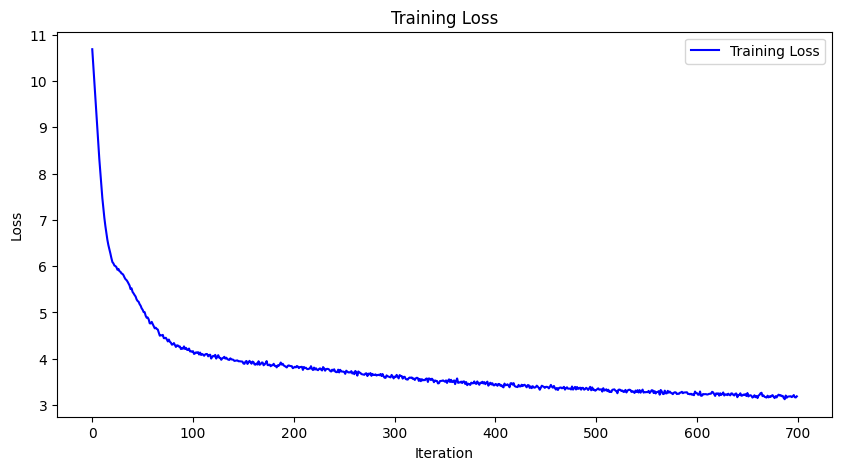

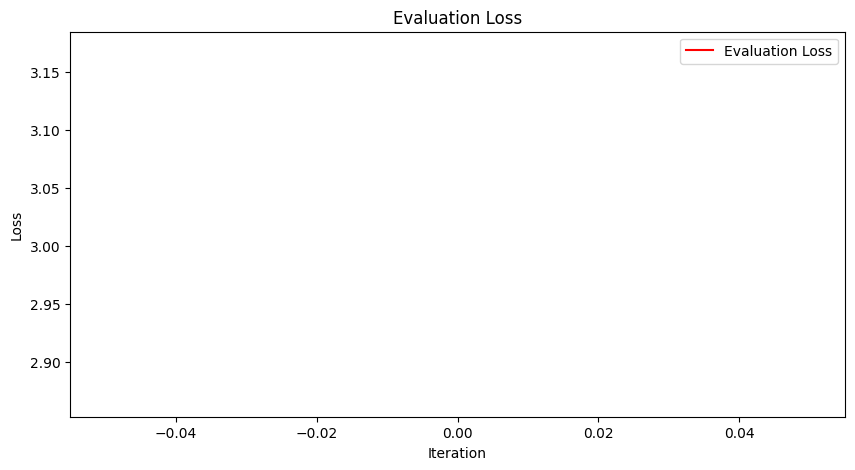

In [ ]:
"""
Training file for the models we implemented
"""

from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.utils
from torch.utils.data import DataLoader
from einops import rearrange
import wandb

from model import BigramLanguageModel, MiniGPT
from dataset import TinyStoriesDataset
from config import BigramConfig, MiniGPTConfig


MODEL = "minigpt"  # bigram or minigpt

if MODEL == "bigram":
    config = BigramConfig
    model = BigramLanguageModel(config)
elif MODEL == "minigpt":
    config = MiniGPTConfig
    model = MiniGPT(config)
else:
    raise ValueError("Invalid model name")


# Initialize wandb if you want to use it
if config.to_log:
    wandb.init()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


train_dataset = TinyStoriesDataset(
    config.path_to_data,
    mode="train",
    context_length=config.context_length,
)
eval_dataset = TinyStoriesDataset(
    config.path_to_data, mode="test", context_length=config.context_length
)

train_dataloader = DataLoader(
    train_dataset, batch_size=config.batch_size, pin_memory=True
)
eval_dataloader = DataLoader(
    eval_dataset, batch_size=config.batch_size, pin_memory=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("number of trainable parameters: %.2fM" % (count_parameters(model) / 1e6,))


if not Path.exists(config.save_path):
    Path.mkdir(MiniGPTConfig.save_path, parents=True, exist_ok=True)


### ==================== START OF YOUR CODE ==================== ###
"""
You are required to implement the training loop for the model.

Please keep the following in mind:
- You will need to define an appropriate loss function for the model.
- You will need to define an optimizer for the model.
- You are required to log the loss (either on wandb or any other logger you prefer) every `config.log_interval` iterations.
- It is recommended that you save the model weights every `config.save_iterations` iterations you can also just save the model with the best training loss.

Please check the config file to see the different configurations you can set for the model.
NOTE :
The MiniGPT config has params that you do not need to use, these were added to scale the model but are
not a required part of the assignment.
Feel free to experiment with the parameters and I would be happy to talk to you about them if interested :)
"""
import torch.optim as optim
import os
import matplotlib.pyplot as plt

def train(model, train_dataloader, eval_dataloader, config):
    model.to(device)
    model.train()

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    # Optionally initialize wandb logging
    if config.to_log:
        wandb.watch(model)

    # Lists to store loss values for plotting
    train_losses = []
    eval_losses = []
    #####

    #####

    # Training loop
    for epoch in range(config.max_iter):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader, 0):
            ########
            if i >= 7000:
                break
            ########
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Log statistics
            running_loss += loss.item()
            if i % config.log_interval == (config.log_interval - 1):  # Log every log_interval mini-batches
                avg_loss = running_loss / config.log_interval
                print(f"[{epoch + 1}, {i + 1}] loss: {avg_loss:.3f}")
                train_losses.append(avg_loss)
                if config.to_log:
                    wandb.log({"loss": avg_loss})
                    print('loss:', avg_loss)
                running_loss = 0.0

            # Save the model every save_iterations
            if i % config.save_iterations == (config.save_iterations - 1):
                save_model(model, config.save_path, epoch, i)

        # Optionally evaluate the model after each epoch
        eval_loss = evaluate(model, eval_dataloader, config, criterion)
        eval_losses.append(eval_loss)

    print("Finished Training")
    save_model(model, config.save_path, epoch, i)

    # Plot the losses
    plot_losses(train_losses, eval_losses, config)

def evaluate(model, eval_dataloader, config, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        i = 0
        for data in eval_dataloader:
            if i >= 7000:
              break
            i += 1
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
            total_loss += loss.item()

    avg_loss = total_loss / 7000
    print(f"Evaluation loss: {avg_loss:.3f}")
    if config.to_log:
        wandb.log({"eval_loss": avg_loss})
    model.train()
    return avg_loss

def save_model(model, path, epoch, iteration):
    save_path = os.path.join(path, f"model_epoch{epoch}_iter{iteration}.pth")
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

def plot_losses(train_losses, eval_losses, config):
    # Plot Training Loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.savefig(os.path.join(config.save_path, 'training_loss_plot.png'))
    plt.show()

    # Plot Evaluation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(eval_losses, label='Evaluation Loss', color='red')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Evaluation Loss')
    plt.legend()
    plt.savefig(os.path.join(config.save_path, 'evaluation_loss_plot.png'))
    plt.show()

# Start the training process
train(model, train_dataloader, eval_dataloader, config)











### Train and Valid Plots


** Show the training and validation loss plots **

### Generation (5 points)


Perform generation with the model that you trained. Copy over the generation function you used for the Bigram model not the `miniGPT` class and generate a mini story using the same seed sentence.

    `"once upon a time"`

In [ ]:

# tokenizer = tiktoken.get_encoding("gpt2")
# gen_sent = "Once upon a time"
# gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
# print("Generating text starting with:", gen_tokens.shape)
# gen_tokens = gen_tokens.to(device)
# model.to(device)
# model.eval()
# print(
#     tokenizer.decode(
#         model.generate(gen_tokens, max_new_tokens=200).squeeze().tolist()
#     )
# )
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = tiktoken.get_encoding("gpt2")
print(device)
# Input sentence
gen_sent = "Once upon a time"

# Encode the input sentence
gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
gen_tokens = gen_tokens.to(device)
print("Generating text starting withh:", gen_tokens)

# Initialize and evaluate your model
model.to(device)
model.eval()

# Generate new tokens
generated_tokens = model.generate(gen_tokens, max_new_tokens=200)

# Decode the generated tokens back to text
generated_text = tokenizer.decode(generated_tokens)
print(generated_text)

cuda
Generating text starting withh: tensor([7454, 2402,  257,  640], device='cuda:0')


/content/drive/.shortcut-targets-by-id/1UJj3AdgcR_Ocb-ytuptvDIHzKtU_FcA1/MiniGPT/model.py:724: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context = torch.tensor(context, dtype=torch.long).unsqueeze(0).to(self.pos.device)  # Convert context to tensor, add batch dimension, and move to device


Once upon a time, there was a little girl named Lily. Lily met a little bird named Lily. She loved to eat butterflies. She had a special pretable line on the night friends, and daddy promised to others and arrive. From that day on, Lily remembered to be brave and the ocean with popcorn.
Lily ate it for her day on, Lily was glad she needed fair. She didn't listen to take her paws. As she found it. She said to have no longer. Lily walked for herself. 
Lily and said, "Mommy, Mommy, what happened. Can I go less so smart, Lily!" 
After playing, Lily showed them crying. She said, "You need a package." Her mommy said, "I want to go on, but your pleasure."
Lily nodded to the boys tried to come.Once upon a time, there was a girl named Lily. She loved to play in the park with her toys and slide. One


Please answer the following questions.

1. What can we say about the generated text in terms of grammar and coherence?
2. If the model is scaled with more parameters do you expect the GPT model to get substantially better? Why or why not?

The generated text is not very coherent and the story doesn't make much sense. The grammar is mostly ok. Due to the GPU limits in Colab, we weren't able to generate a model much better than this one. If the model is scaled with substantially more parameters we expect the GPT model to get substantially better due to being able to generate and recognize more complex patterns and grammatical structures (i.e. what types of words should be grouped with what other types of words). With more parameters, there is an increased risk of potentially overfitting to the data which is undesirable, and was definitely something that we considered as we were trained models with different parameters to generate the above text


### Scaling up the model (5 points)

To show that scale indeed will help the model learn we have trained a scaled up version of the model you just implemented. We will load the weights of this model and generate a mini story using the same seed sentence. Note that if you have implemented the model correctly just scaling the parameters and adding a few bells and whistles to the training script will results in a model like the one we will load now.

In [ ]:
from model import MiniGPT
from config import MiniGPTConfig

In [ ]:
path_to_trained_model = "pretrained_models/best_train_loss_checkpoint.pth"

In [ ]:
ckpt = torch.load(path_to_trained_model, map_location=device) # remove map location if using GPU

In [ ]:
# Set the configs for scaled model
MiniGPTConfig.context_length = 512
MiniGPTConfig.embed_dim = 256
MiniGPTConfig.num_heads = 16
MiniGPTConfig.num_layers = 8

In [ ]:
# Load model from checkpoint
model = MiniGPT(MiniGPTConfig)
model.load_state_dict(ckpt["model_state_dict"])

<All keys matched successfully>

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
model.to(device)
# gen_sent = "Once upon a time"
# gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
# print("Generating text starting with:", gen_tokens.shape)
# gen_tokens = gen_tokens.to(device)
# model.eval()
# print(
#     tokenizer.decode(
#         model.generate(gen_tokens, max_new_tokens=200).squeeze().tolist()
#     )
# )
# tokenizer = tiktoken.get_encoding("gpt2")
print(device)
# Input sentence
gen_sent = "Once upon a time"

# Encode the input sentence
gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
gen_tokens = gen_tokens.to(device)
print("Generating text starting withh:", gen_tokens.shape)

# Initialize and evaluate your model
# model.to(device)
model.eval()

# Generate new tokens
generated_tokens = model.generate(gen_tokens, max_new_tokens=200)

# Decode the generated tokens back to text
generated_text = tokenizer.decode(generated_tokens)
print(generated_text)

cuda
Generating text starting withh: torch.Size([4])
Once upon a time, there was a little boy named Tim. Tim had a big, dark shield. He loved to play with it every day. One day, Tim saw a little cat stuck in a tree. The cat was scared. Tim dared the cat to help it get down from the tree.
Tim thought of a plan. He put his shield in the tree and climbed up. The cat climbed up and saved the cat. The cat was very happy and thanked Tim. They became best friends.
But then, something unexpected happened. While they were away from the tree, the shield started to talk! It said, "Thank you for your help. I was stuck in that shield." Tim and the cat were very surprised. They did not expect the talking cat to their friendship. They all became friends and played together every day.Once upon a time, there was a little girl named Mia. Mia had a fragile toy bunny that she loved very much. One day, Mia and her bunny went on


## Bonus (5 points)

The following are some open ended questions that you can attempt if you have time. Feel free to propose your own as well if you have an interesting idea.

1. The model we have implemented is a decoder only model. Can you implement the encoder part as well? This should not be too hard to do since most of the layers are already implemented.
2. What are some improvements we can add to the training script to make training more efficient and faster? Can you concretely show that the improvements you made help in training the model better?
3. Can you implement a beam search decoder to generate the text instead of greedy decoding? Does this help in generating better text?
4. Can you further optimize the model architecture? For example, can you implement [Multi Query Attention](https://arxiv.org/abs/1911.02150) or [Grouped Query Attention](https://arxiv.org/pdf/2305.13245) to improve the model performance?